In [1]:
#imports
import math
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter

In [2]:
df=pd.read_csv('data.csv')
i=0
st_ind=[]
end_ind=[]
while(i<39482):
    if(df["Eye movement type"][i]=="Fixation"):
        st_ind.append(i)
        while(df["Eye movement type"][i]=="Fixation"):
            i+=1
        end_ind.append(i-1)
    i+=1

In [3]:
v=[]
cnt=0
for i,j in zip(st_ind,end_ind):
    if(cnt>100):
        break
    cnt+=1
    t1=df["time"][i]
    t2=df["time"][j]
    x=df["Fixation point X"][i]
    y=df["Fixation point Y"][i]
    v.append([x,y,t1,t2])
v[0][2]=0
Vk=[v]

In [4]:
th_tv=[0, 500, 1000, 1500, 2000, 2500, 3000]
th_sv=[0, 50,75, 100, 150, 200, 250]

In [5]:
def mdist(a,b):
    d=(a[0]-b[0]) **2 + (a[1]-b[1]) **2
    d=math.sqrt(d)
    return d
def dist(a,b):
    d=(a[0]-b[0]) **2 + (a[1]-b[1]) **2
    return d
def bfs(v,i,th_s,check):
    #global check
    if(check[i]==True):
        return
    global parent
    global p
    q=[[v[i][0],v[i][1]]]
    parent.append([])
    parent[p].append(i)
    check[i]=True
    while(len(q)!=0):
        sz=len(q)
        while(sz>0):
            sz-=1
            t=q.pop(0)
            #print(t)
            for x in range(len(v)):
                if(check[x]==False):
                    if(dist(t,[v[x][0],v[x][1]])<th_s*th_s):
                        check[x]=True
                        if(len(parent)>p):
                            parent[p].append(x)
                        else:
                            parent.append([])
                            parent[p].append(x)
                        q.append([v[x][0],v[x][1]])
    p +=1

In [6]:
def dist2(a,b):
    d1=min(abs(a[0]-b[1]),abs(a[1]-b[0]))
    return d1
def bfs2(v,arr,i,th_t,check2):
    #check2=[False for i in len(arr)]
    if(check2[i]==True):
        return
    q=[[v[arr[i]][2],v[arr[i]][3]]]
    check2[i]=True
    global cluster
    global num
    #cluster.append([])
    #num+=1
    if(len(cluster)>num):
        cluster[num].append(arr[i])
    else:
        cluster.append([])
        #print(num)
        cluster[num].append(arr[i])
    while(len(q)!=0):
        sz=len(q)
        while(sz>0):
            sz-=1
            t=q.pop(0)
            for x in range(len(arr)):
                if(check2[x]==False):
                    #print(t)
                    if(dist2(t,[v[arr[x]][2],v[arr[x]][3]])<th_t):
                        check2[x]=True
                        if(len(cluster)>num):
                            cluster[num].append(arr[x])
                        else:
                            cluster.append([])
                            #print(num)
                            cluster[num].append(arr[x])
                        q.append([v[arr[x]][2],v[arr[x]][3]])
    num+=1

In [7]:
def new(v,cluster):
    new_v=np.zeros(shape=[len(cluster),4],dtype=float)
    for i in range(len(cluster)):
        sum1=0
        sum2=0
        sum3=v[cluster[i][0]][2]
        sum4=v[cluster[i][0]][3]
        w=len(cluster[i])
        for j in range(w):
            sum1+=v[cluster[i][j]][0]
            sum2+=v[cluster[i][j]][1]
            if(sum3>v[cluster[i][j]][2]):
                sum3=v[cluster[i][j]][2]
            if(sum4<v[cluster[i][j]][3]):
                sum4=v[cluster[i][j]][3]
        sum1/=w
        sum2/=w
        new_v[i][0]=sum1
        new_v[i][1]=sum2
        new_v[i][2]=sum3
        new_v[i][3]=sum4
    new_v=sorted(new_v,key=itemgetter(2))
    return new_v
    

In [8]:
def dtw_f(v,new_v):
    dtw=np.zeros(shape=[len(v),len(new_v)],dtype=float)
    for i in range(len(v)):
        for j in range(len(new_v)):
            if(i!=0 and j!=0):
                x=min(dtw[i][j-1],dtw[i-1][j-1],dtw[i-1][j])
                dtw[i][j]=x+mdist([v[i][0],v[i][1]],[new_v[j][0],new_v[j][1]])
            else:
                dtw[i][j]=mdist([v[i][0],v[i][1]],[new_v[j][0],new_v[j][1]])
    i=len(v)-1
    j=len(new_v)-1
    sum=0
    #print(dtw)
    while(i!=0 and j!=0):
        sum+=dtw[i][j]
        x=dtw[i-1][j-1]
        y=dtw[i][j-1]
        z=dtw[i-1][j]
        if(x<=y and x<=z):
            i=i-1
            j=j-1
        elif(y<=x and y<=z):
            j=j-1
        else:
            i=i-1
    if(i==0):
        while(j>=0):
            sum+=dtw[i][j]
            j-=1
    if(j==0):
        while(i>=0):
            sum+=dtw[i][j]
            i-=1
    return sum

In [29]:
def timesh(best,c_best,image):
    d=0
    k=int(255/(len(best)-1))
    for i in range(len(best)):
        centre=(int(best[i][0]),int(best[i][1]))
        radius=len(c_best[i])*4+10
        if(radius<10):
            radius=10
        color=(0,255-d,255)
        d+=k
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 0.5
        color2=(0,0,0)
        if i!=0:
            cv2.line(image,prev,centre,color,2)
        cv2.circle(image,centre,radius,color,-1)
        cv2.circle(image,centre,radius,color2,2)
        cv2.putText(image, str(i+1), centre, font,fontScale,color2, 2, cv2.LINE_AA)
        prev=centre
    cv2.imshow("Time scheme",image)
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()

In [10]:
def plotdtw(graphs_dtw):
    for i,j in graphs_dtw.items():
        plt.plot(th_tv, j,marker='o',markersize=12, label = str(i))
    plt.xlabel('theata t ms')
    plt.ylabel('y-axis')
    plt.legend()
    plt.show()
def plotef(graphs_ef):
    for i,j in graphs_ef.items():
        plt.plot(th_tv, j,marker='o',markersize=12, label = str(i))
    plt.xlabel('theata t ms')
    plt.ylabel('y-axis')
    plt.legend()
    plt.show()

In [11]:
graphs_dtw={}
graphs_ef={}
for i in th_sv:#th_sv
    graphs_dtw[i]=[]
    graphs_ef[i]=[]
    for j in th_tv:#th_tv
        sumdtw=0
        sumef=0
        for k in Vk:
            parent=[]
            raw=len(k)
            check=np.array([False for x in range(raw)],dtype=bool)
            p=0
            for x in range(raw):
                bfs(k,x,i,check)
            num=0
            cluster=[]
            for y in range(len(parent)):
                check2=np.array([False for i in range(len(parent[y]))],dtype=bool)
                for z in range(len(parent[y])):
                    bfs2(k,parent[y],z,j,check2)
            new_v=new(k,cluster)
            dtw=dtw_f(k,new_v)
            dtw/=raw+len(new_v)
            sumdtw+=dtw
            sumef+=len(new_v)
        sumdtw /=len(Vk)
        sumef /=len(Vk)
        #print(sumdtw)
        graphs_dtw[i].append(sumdtw)
        graphs_ef[i].append(sumef)

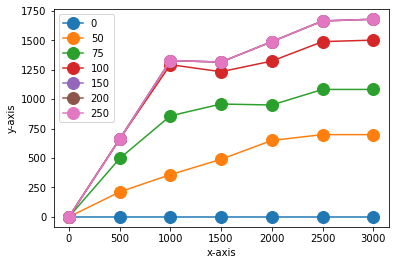

In [12]:
plotdtw(graphs_dtw)

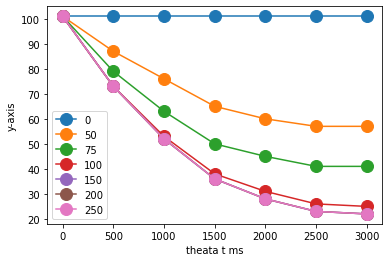

In [13]:
plotef(graphs_ef)

In [27]:
pqsz=len(cluster)
pmin=2
kj=0
while(kj<pqsz):
    if(len(cluster[kj])<pmin):
        del cluster[kj]
        kj-=1
        pqsz-=1
    kj+=1
new_v=new(v,cluster)

In [31]:
image = 255 * np.ones(shape=[1000, 2000, 3], dtype=np.uint8)
best=[]
for i in new_v:
      best.append([(i[0])*1.3-400,(i[1])*1.3-350])
c_best=cluster
timesh(best,c_best,image)

In [26]:
n=len(v)
th_s=75
check=[False for i in range(n)]
parent=[]
p=0
for i in range(n):
    bfs(v,i,th_s,check)
num=0
th_t=1500
cluster=[]
for i in range(len(parent)):
    check2=[False for k in range(len(parent[i]))]
    for j in range(len(parent[i])):
        bfs2(v,parent[i],j,th_t,check2)